# Reading NEHX trees into matrices 


In [2]:
from Bio import Phylo
from io import StringIO
import pandas as pd
import numpy as np
import h5py
from scipy.sparse import csr_matrix, save_npz
import os
import sys


In [ ]:
import pandas as pd
species_id = pd.read_csv("species_id.csv", header=None, index_col=1)
species_id.columns = ["species"]
species_id.index.name = "id"

species_id_dict = species_id.to_dict()
species_id_dict = species_id_dict["species"]
# species_id_dict

In [ ]:
def get_ancestors(node, species_name, matrix, row, col, adjacency_df):
    try:
        ancestor = adjacency_df.loc[adjacency_df[node] == 1].index[0]
    except:
        ancestor = None
    if ancestor != None:
        matrix[row.index(ancestor), col.index(species_name)] = 1
        return get_ancestors(ancestor, species_name, matrix, row, col, adjacency_df)

In [ ]:
# i feel like you don't need to store data, since it's all 1's

def create_h5_file(matrix, matrix_name, output_dir, count, row, column=""):
    with h5py.File(f"{output_dir}/{matrix_name}_{count}.h5", "w") as f:
        matrix_sparse = csr_matrix(matrix)
        # f.create_dataset(f'{matrix_name}_data', data=matrix_sparse.data, compression="gzip", compression_opts=9)
        f.create_dataset(f'{matrix_name}_indices', data=matrix_sparse.indices, compression="gzip", compression_opts=9)
        f.create_dataset(f'{matrix_name}_indptr', data=matrix_sparse.indptr, compression="gzip", compression_opts=9)
        f.create_dataset(f'{matrix_name}_shape', data=matrix_sparse.shape, compression="gzip", compression_opts=9)
        f.create_dataset(f'{matrix_name}_rows', data=np.array(row, dtype='S'), compression="gzip", compression_opts=9)
        if column:
            f.create_dataset(f'{matrix_name}_columns', data=np.array(column, dtype='S'), compression="gzip", compression_opts=9)


In [ ]:
def create_matrices(tree_str, species_id_dict, count=1, print_tree=False, save_files=False, output_dir="."):
    # tic = time.perf_counter()
    tree = Phylo.read(StringIO(tree_str), "newick")
    node = 0
    num_nodes = 0
    internal_nodes = 0
    terminal_nodes = 0
    event_row = []
    species_row = [] # ids 
    species_col = [] # names
    species_internal_row = []
    
    # initialize events, species, and adjacency matrix
    for clade in tree.find_clades():
        num_nodes += 1
        if clade.name == None:
            clade.name = str(internal_nodes)
            internal_nodes += 1
            species_internal_row.append(clade.name)
        else:
            terminal_nodes += 1
            species_row.append(clade.name)
            try:
                species_name = species_id_dict[clade.name]
            except:
                species_name = clade.name
            species_col.append(species_name)
        event_row.append(clade.name)
        
    event_columns = ["leaf", "duplication", "speciation"]
    events = np.zeros((num_nodes, 3))
    species = np.zeros((terminal_nodes, len(species_row))) 
    # adjacency matrix
    parent = event_row.copy()
    adjacency = np.zeros((len(parent), len(parent)))
    # internal - species matrix
    species_internal = np.zeros((internal_nodes, len(species_row)))

    # fill out matrices
    for clade in tree.find_clades():
        if ':[' in clade.name:
            name, nhx_string = clade.name.split(':[')
            nhx_tags = nhx_string.rstrip(']').split(':')
            nhx_data = {}
            for tag in nhx_tags:
                key, value = tag.split('=')
                nhx_data[key] = value
            clade.name = name
            clade.comment = str(nhx_data)

        # Event matrix
        # row = node, column = event type
        if str(clade.name).isdigit(): # internal node
            if "D=Y" in clade.comment: # duplication
                events[node] = [0, 1, 0]
            elif "D=N" in clade.comment: # speciation
                events[node] = [0, 0, 1]
            else: # idk, throw a warning?
                break
        else: # leaf node
            events[node] = [1, 0, 0]

        # Species matrix
        # row = species, column = species name
        if clade.name in species_row:
            try:
                species_name = species_id_dict[clade.name]
                species[species_row.index(clade.name), species_col.index(species_name)] = 1
            except:
                pass # species isn't defined in SEQ, will not have entry in species, [FIX LATER]            
        node += 1
    # Adjacency matrix
    # row = parent, column = child
    for clade in tree.get_nonterminals():
        parent_node = clade.name
        children = [child.name for child in clade.clades]
        for child in children:
            adjacency[parent.index(parent_node), parent.index(child)] = 1

    # Fill out species-internal node matrix
    # row = internal node, column = species
    adjacency_df = pd.DataFrame(adjacency, index=parent, columns=parent)
    for leaf in tree.get_terminals():
        species_name = species_id_dict[leaf.name]
        get_ancestors(leaf.name, species_name, species_internal, species_internal_row, species_col, adjacency_df)
    
    # Draw tree
    # add speciation / duplication events
    if print_tree:
        # for clade in tree.find_clades():
        #     if clade.name.isdigit():
        #         if "D=Y" in clade.comment:
        #             clade.name += "(D)"
        #         elif "D=N" in clade.comment:
        #             clade.name += "(S)"
        Phylo.draw(tree)
                
    if save_files:
        if not os.path.exists(f"{output_dir}/"):
            os.makedirs(f"{output_dir}/")
        create_h5_file(events, "events", output_dir, count, event_row, event_columns)
        create_h5_file(species, "species", output_dir, count, species_row, species_col)
        create_h5_file(adjacency, "adjacency", output_dir, count, parent)
        create_h5_file(species_internal, "species_internal", output_dir, count, species_internal_row)

        # with h5py.File(f"{output_dir}/event_{count}.h5", "w") as f:
        #     event_sparse = csr_matrix(events)
        #     f.create_dataset('events_data', data=event_sparse.data, compression="gzip", compression_opts=9)
        #     f.create_dataset('events_indices', data=event_sparse.indices, compression="gzip", compression_opts=9)
        #     f.create_dataset('events_indptr', data=event_sparse.indptr, compression="gzip", compression_opts=9)
        #     f.create_dataset('events_shape', data=event_sparse.shape, compression="gzip", compression_opts=9)
        #     f.create_dataset("event_rows", data=np.array(event_row, dtype='S'), compression="gzip", compression_opts=9)
        #     f.create_dataset("event_columns", data=np.array(event_columns, dtype='S'), compression="gzip", compression_opts=9)

        # with h5py.File(f"{output_dir}/species_{count}.h5", "w") as f:
        #     species_sparse = csr_matrix(species)
        #     f.create_dataset('species_data', data=species_sparse.data, compression="gzip", compression_opts=9)
        #     f.create_dataset('species_indices', data=species_sparse.indices, compression="gzip", compression_opts=9)
        #     f.create_dataset('species_indptr', data=species_sparse.indptr, compression="gzip", compression_opts=9)
        #     f.create_dataset('species_shape', data=species_sparse.shape, compression="gzip", compression_opts=9)
        #     f.create_dataset("species_rows", data=np.array(species_row, dtype='S'), compression="gzip", compression_opts=9)
        #     f.create_dataset("species_columns", data=np.array(species_col, dtype='S'), compression="gzip", compression_opts=9)
                
        # with h5py.File(f"{output_dir}/adjacency_{count}.h5", "w") as f:
        #     adjacency_sparse = csr_matrix(adjacency)
        #     f.create_dataset('adjacency_data', data=adjacency_sparse.data, compression="gzip", compression_opts=9)
        #     f.create_dataset('adjacency_indices', data=adjacency_sparse.indices, compression="gzip", compression_opts=9)
        #     f.create_dataset('adjacency_indptr', data=adjacency_sparse.indptr, compression="gzip", compression_opts=9)
        #     f.create_dataset('adjacency_shape', data=adjacency_sparse.shape, compression="gzip", compression_opts=9)
        #     f.create_dataset("parent", data=np.array(parent, dtype='S'), compression="gzip", compression_opts=9)
        #     # f.create_dataset("child", data=np.array(parent, dtype='S'), compression="gzip", compression_opts=9)

        # with h5py.File(f"{output_dir}/species_internal_{count}.h5", "w") as f:
        #     species_internal_sparse = csr_matrix(species_internal)
        #     f.create_dataset('species_internal_data', data=species_internal_sparse.data, compression="gzip", compression_opts=9)
        #     f.create_dataset('species_internal_indices', data=species_internal_sparse.indices, compression="gzip", compression_opts=9)
        #     f.create_dataset('species_internal_indptr', data=species_internal_sparse.indptr, compression="gzip", compression_opts=9)
        #     f.create_dataset('species_internal_shape', data=species_internal_sparse.shape, compression="gzip", compression_opts=9)
        #     f.create_dataset("species_internal_row", data=np.array(species_internal_row, dtype='S'), compression="gzip", compression_opts=9)'

        # print(f"Saving files: {toc - tic:0.4f} seconds")

    # npz files
    # if save_files:
    #     if not os.path.exists(f"{output_dir}/"):
    #         os.makedirs(f"{output_dir}/")
    #     event_sparse = csr_matrix(events)        
    #     save_npz(f'{output_dir}/events.npz', event_sparse)
    #     np.save(f'{output_dir}/event_row.npy', event_row)
    #     np.save(f'{output_dir}/event_columns.npy', event_columns)

    #     species_sparse = csr_matrix(species)        
    #     save_npz(f'{output_dir}/species.npz', species_sparse)
    #     np.save(f'{output_dir}/species_row.npy', species_row)
    #     np.save(f'{output_dir}/species_columns.npy', species_col)

    #     adjacency_sparse = csr_matrix(adjacency)        
    #     save_npz(f'{output_dir}/adjacency.npz', adjacency_sparse)
    #     np.save(f'{output_dir}/adjacency_indices.npy', parent)
    #     # np.save(f'{output_dir}/adjacency_columns.npy', child)

    else:
        return tree, events, event_row, event_columns, species, species_row, species_col, species_internal, species_internal_row, adjacency, parent
    

In [ ]:
tree_str = "(((((ENSXMAP00000023154:0.003798[&&NHX:D=N:G=ENSXMAG00000029135:T=8083],ENSXCOP00000022609:0.005509[&&NHX:D=N:G=ENSXCOG00000016899:T=32473]):0.183284[&&NHX:D=N:B=100:T=8082],ENSPREP00000021178:0.084207[&&NHX:D=N:G=ENSPREG00000014319:T=8081]):0.097357[&&NHX:D=N:B=96:T=586240],ENSOJAP00000021525:0.241724[&&NHX:D=N:G=ENSOJAG00000011071:T=123683]):0.166728[&&NHX:D=N:B=89:T=1489913],ENSBSLP00000031907:0.317255[&&NHX:D=N:G=ENSBSLG00000015692:T=158456]):0.0954935[&&NHX:D=N:B=93:T=1489872],(((ENSOCUP00000048526:0.075568[&&NHX:D=N:G=ENSOCUG00000032515:T=9986],ENSPEMP00000032668:0.223749[&&NHX:D=N:G=ENSPEMG00000024427:T=230844]):0.020571[&&NHX:D=N:B=14:T=314147],(((((((ENSMLEP00000032590:0.002705[&&NHX:D=N:G=ENSMLEG00000040506:T=9568],ENSCATP00000005008:0.002706[&&NHX:D=N:G=ENSCATG00000016933:T=9531]):0[&&NHX:D=N:B=75:T=9528],ENSMNEP00000009280:0.008163[&&NHX:D=N:G=ENSMNEG00000029102:T=9545]):0.007223[&&NHX:D=N:B=67:T=9528],(ENSRBIP00000014183:0[&&NHX:D=N:G=ENSRBIG00000031198:T=61621],ENSRROP00000004625:0.008118[&&NHX:D=N:G=ENSRROG00000019173:T=61622]):0.009148[&&NHX:D=N:B=99:T=542827]):0.008681[&&NHX:D=N:B=77:T=9527],(((ENSPPAP00000008835:0[&&NHX:D=N:G=ENSPPAG00000027666:T=9597],ENSPTRP00000065716:0[&&NHX:D=N:G=ENSPTRG00000043129:T=9598]):0.003148[&&NHX:D=N:B=98:T=9596],ENSGGOP00000045929:0.007554[&&NHX:D=N:G=ENSGGOG00000036615:T=9595]):0.003046[&&NHX:D=N:B=97:T=207598],ENSNLEP00000044342:0.022034[&&NHX:D=N:G=ENSNLEG00000031632:T=61853]):0.020141[&&NHX:D=N:B=93:T=314295]):0.002521[&&NHX:D=N:B=31:T=9526],((ENSSBOP00000017696:0.010962[&&NHX:D=N:G=ENSSBOG00000025494:T=39432],ENSCCAP00000009427:0.013385[&&NHX:D=N:G=ENSCCAG00000022455:T=2715852]):0[&&NHX:D=N:B=98:T=9498],ENSANAP00000042340:0.022526[&&NHX:D=N:G=ENSANAG00000038453:T=37293]):0.006841[&&NHX:D=N:B=84:T=9479]):0.049508[&&NHX:D=N:B=33:T=314293],ENSTSYP00000020254:0.070134[&&NHX:D=N:G=ENSTSYG00000028801:T=1868482]):0.02796[&&NHX:D=N:B=81:T=376913],(ENSPCOP00000028138:0.042488[&&NHX:D=N:G=ENSPCOG00000026660:T=379532],ENSMICP00000022845:0.061846[&&NHX:D=N:G=ENSMICG00000026747:T=30608]):0.030486[&&NHX:D=N:B=84:T=376915]):0.023044[&&NHX:D=N:B=41:T=9443]):0.018311[&&NHX:D=N:B=10:T=314146],(((((ENSCAFP00020019180:0[&&NHX:D=N:G=ENSCAFG00020015228:T=286419],ENSCAFP00845000643:0[&&NHX:D=N:G=ENSCAFG00845000527:T=9615]):0.156455[&&NHX:D=N:B=100:T=9612],ENSNVIP00000014581:0.141636[&&NHX:D=N:G=ENSNVIG00000011446:T=452646]):0[&&NHX:D=N:B=3:T=379584],ENSPPRP00000022180:0.093979[&&NHX:D=N:G=ENSPPRG00000012771:T=9691]):0.023937[&&NHX:D=N:B=0:T=33554],ENSRFEP00010028870:0.193458[&&NHX:D=N:G=ENSRFEG00010019164:T=59479]):0.006404[&&NHX:D=N:B=0:T=314145],((((((ENSBIXP00005040091:0[&&NHX:D=N:G=ENSBIXG00005022637:T=30522],ENSBTAP00000068471:0[&&NHX:D=N:G=ENSBTAG00000053937:T=9913]):0[&&NHX:D=N:B=100:T=9903],ENSBMUP00000019409:0.011437[&&NHX:D=N:G=ENSBMUG00000014671:T=72004]):0.051785[&&NHX:D=N:B=100:T=9903],ENSCHIP00000007234:0.057798[&&NHX:D=N:G=ENSCHIG00000010813:T=9925]):0.019898[&&NHX:D=N:B=79:T=9895],ENSMMSP00000011301:0.118558[&&NHX:D=N:G=ENSMMSG00000008670:T=68415]):0.022114[&&NHX:D=N:B=22:T=35500],ENSCHYP00000037892:0.107299[&&NHX:D=N:G=ENSCHYG00000025218:T=84702]):0.177423[&&NHX:D=N:B=33:T=35500],ENSBMSP00010012664:0.111443[&&NHX:D=N:G=ENSBMSG00010009296:T=9771]):0.032228[&&NHX:D=N:B=71:T=91561]):0.034169[&&NHX:D=N:B=2:T=314145]):0.16388[&&NHX:D=N:B=29:T=1437010]):0[&&NHX:D=N:B=0:T=117571];"

# tree, events, event_row, event_columns, species, species_row, species_col, species_internal, species_internal_row, adjacency, parent = create_matrices(tree_str, species_id_dict, print_tree=True, save_files=False, output_dir="./out")
create_matrices(tree_str, species_id_dict, print_tree=True, save_files=True, output_dir="./out")

# 0.8 seconds (if not saving file)
# 1.0 seconds (if saving file)

In [3]:
import h5py

def print_h5py_file(filename, matrix_name, cols=[]):
    with h5py.File(filename, "r") as f:
        # matrix = np.array(f[f"{matrix_name}_data"])
        indices = np.array(f[f"{matrix_name}_indices"])
        indptr = np.array(f[f"{matrix_name}_indptr"])
        rows = np.array(f[f"{matrix_name}_rows"]).astype('S').astype('U')  
        if matrix_name == "species":
            cols = np.array(f[f"{matrix_name}_columns"]).astype('S').astype('U')  
        elif matrix_name == "species_internal":
            filename = filename.replace("species_internal", "species")
            data = np.array(f[f"{matrix_name}_data"])
            shape = np.array(f[f"{matrix_name}_shape"])
        
    if matrix_name == "events":
        cols = ["leaf", "duplication", "speciation"]
    elif matrix_name == "adjacency":
        cols = rows
    if matrix_name != "species_internal": 
        df = pd.DataFrame(0, index=rows, columns=cols)
        for i, j in zip(indices, indptr):
            df.loc[rows[j], cols[i]] = 1
    else: 
        original_array = csr_matrix((data, indices, indptr), shape=tuple(shape)).toarray()
        df = pd.DataFrame(original_array, index=rows, columns=cols)
    return df, indices, indptr, rows, cols

e_df ,e_index, e_indptr, e_rows, e_cols = print_h5py_file("brain/50/events_0.h5", "events")
a_df, a_index, a_indptr, a_rows, a_cols = print_h5py_file("brain/50/adjacency_1.h5", "adjacency")
s_df, s_index, s_indptr, s_rows, s_cols = print_h5py_file("brain/50/species_1.h5", "species")
i_df, i_index, i_indptr, i_rows, i_cols = print_h5py_file("brain/50/species_internal_1.h5", "species_internal", cols=s_cols)


In [ ]:
print(i_index, i_indptr)
# create dataframe of size len(rows) x len(cols) and fill in 1's at indices
e_cols = ["leaf", "duplication", "speciation"]
e_rows_str = [i.decode("utf-8") for i in e_rows]

e_df = pd.DataFrame(0, index=e_rows_str, columns=e_cols)
for i, j in zip(e_index, e_indptr):
    e_df.loc[e_rows_str[j], e_cols[i]] = 1
e_df

In [ ]:
from scipy.sparse import load_npz
# load npz files
event_sparse = load_npz('test_100/1/events.npz')
species_sparse = load_npz('test_100/1/species.npz')
adjacency_sparse = load_npz('test_100/1/adjacency.npz')
event_row = np.load('test_100/1/event_row.npy', allow_pickle=True)
event_columns = np.load('test_100/1/event_columns.npy', allow_pickle=True)
species_row = np.load('test_100/1/species_row.npy', allow_pickle=True)
species_columns = np.load('test_100/1/species_columns.npy', allow_pickle=True)
adjacency_row = np.load('test_100/1/adjacency_row.npy', allow_pickle=True)
adjacency_columns = np.load('test_100/1/adjacency_columns.npy', allow_pickle=True)

# print
print(event_sparse)
print(event_row)
print(event_columns)
print(species_sparse)
print(species_row)
print(species_columns)
print(adjacency_sparse)
print(adjacency_row)
print(adjacency_columns)


# Testing
- 100 trees

In [ ]:
# full dataset
import gzip as gz
with gz.open("../trees.txt.gz", "r") as f:
    lines = f.readlines()
    trees = [line.decode("utf-8").strip() for line in lines]


In [ ]:
import os
i = 0
for tree_str in trees:
    if i < 100: i += 1
    else: break
    # tree = Phylo.read(StringIO(tree_str), "newick")     
    if not os.path.exists(f"./test_100/{i}/"):
        os.makedirs(f"./test_100/{i}/")
    create_matrices(tree_str, species_id_dict, i, print_tree=False, save_files=True, output_dir=f"./test_100/{i}")


In [ ]:
test = trees[0]
tree, events, event_row, event_columns, species, species_row, species_col, adjacency, parent, child = create_matrices(tree_str, species_id_dict, i, print_tree=False, save_files=False, output_dir=f"./trees/{i}/")

In [ ]:
import sys
sys.getsizeof(parent)
sys.getsizeof(child)
adjacency.nbytes

# Checking overlap between species in gene trees and brain size dataset

In [1]:
import sys
sys.path.append('../scripts')
from create_matrices import Matrix
import gzip as gz
import regex as re
from io import StringIO
from Bio import Phylo
import pandas as pd

In [2]:
brain_size_df = pd.read_csv("../data/gyz043_suppl_Supplement_Data.csv", header=0)
species_id = pd.read_csv("../data/species_id_gene_id.tsv.gz", compression="gzip",header=0, delimiter="\t")
ensembl_df = species_id.copy()
brain_size_df = brain_size_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
ensembl_df = ensembl_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
ensembl_df.columns = ["Binomial", "species_id", "gene_id", "gene"]
merged = pd.merge(brain_size_df, ensembl_df,on="Binomial", how="inner")
brain_size_species = merged["Binomial"].unique()
species_id.set_index("transcript_id", inplace=True)
species_id_dict = species_id["species"].to_dict()

C:\Users\bunan\AppData\Local\Temp\ipykernel_37704\474406252.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  brain_size_df = brain_size_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
C:\Users\bunan\AppData\Local\Temp\ipykernel_37704\474406252.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ensembl_df = ensembl_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [3]:
merged = pd.merge(brain_size_df, ensembl_df,on="Binomial", how="inner")
brain_size_species = merged["Binomial"].unique()
brain_size_species

array(['echinops_telfairi', 'bos_taurus', 'camelus_dromedarius',
       'capra_hircus', 'sus_scrofa', 'bos_grunniens', 'ursus_maritimus',
       'vulpes_vulpes', 'panthera_pardus', 'ursus_americanus',
       'neovison_vison', 'felis_catus', 'ailuropoda_melanoleuca',
       'panthera_leo', 'tursiops_truncatus', 'delphinapterus_leucas',
       'monodon_monoceros', 'balaenoptera_musculus', 'physeter_catodon',
       'rhinolophus_ferrumequinum', 'pteropus_vampyrus',
       'myotis_lucifugus', 'dasypus_novemcinctus', 'sarcophilus_harrisii',
       'phascolarctos_cinereus', 'vombatus_ursinus',
       'erinaceus_europaeus', 'procavia_capensis', 'ochotona_princeps',
       'oryctolagus_cuniculus', 'ornithorhynchus_anatinus',
       'equus_asinus', 'equus_caballus', 'choloepus_hoffmanni',
       'callithrix_jacchus', 'otolemur_garnettii',
       'propithecus_coquereli', 'chlorocebus_sabaeus',
       'macaca_fascicularis', 'macaca_mulatta', 'rhinopithecus_roxellana',
       'mandrillus_leucophae

In [4]:
import gzip as gz
with gz.open("../data/trees.txt.gz", "r") as f:
    trees = [line.decode("utf-8").strip() for line in f.readlines() if not "--" in line.decode("utf-8").strip()]
    sorted_list = sorted([line.decode("utf-8").strip() for line in f.readlines() if not "--" in line.decode("utf-8").strip()], key=lambda x: len(x))





In [5]:
# Plot number of species in each tree

counts = {}
i = 0

for tree_str in trees:
    species_in_tree = []
    tree_str = re.sub(r"\s+", "", tree_str)
    tree = Phylo.read(StringIO(tree_str), "newick")
    for clade in tree.get_terminals():
        i += 1
        try: species_in_tree.append(species_id_dict[clade.name])
        except: pass
    num = set(species_in_tree)
    if i == 20: 
        print(tree_str)
        break
    counts[len(num)] = counts.get(len(num), 0) + 1    



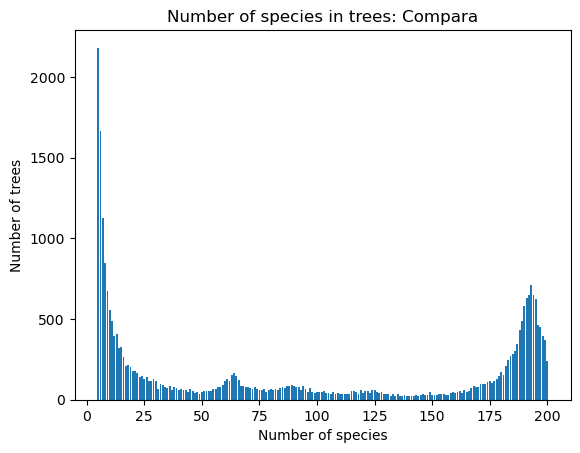

12576

In [6]:

sorted_dict = dict(sorted(counts.items()))
del sorted_dict[1]
del sorted_dict[2]
del sorted_dict[3]
del sorted_dict[4]


import matplotlib.pyplot as plt
plt.bar(sorted_dict.keys(), sorted_dict.values())
plt.xlabel("Number of species")
plt.ylabel("Number of trees") 
plt.title("Number of species in trees: Compara")
plt.show()
# 54673 trees 

greater_than_60 = {k: v for k, v in sorted_dict.items() if k > 100}
sum(greater_than_60.values())

In [7]:
# import gzip as gz
# import regex as re

count_brain = {}
trees_w_threshold = {i: [] for i in range(50, 65)}
with gz.open("../data/trees.txt.gz", "r") as f:
    for line in f:
        line = line.decode("utf-8").strip()
        species_in_tree = []
        tree_str = re.sub(r"\s+", "", line)
        tree = Phylo.read(StringIO(tree_str), "newick")
        for clade in tree.get_terminals():
            try: species_in_tree.append(species_id_dict[clade.name])
            except: pass
        num = set(species_in_tree).intersection(brain_size_species)
        try: 
            if len(num) >=50: trees_w_threshold[len(num)].append(line)
        except: pass
        count_brain[len(num)] = count_brain.get(len(num), 0) + 1   


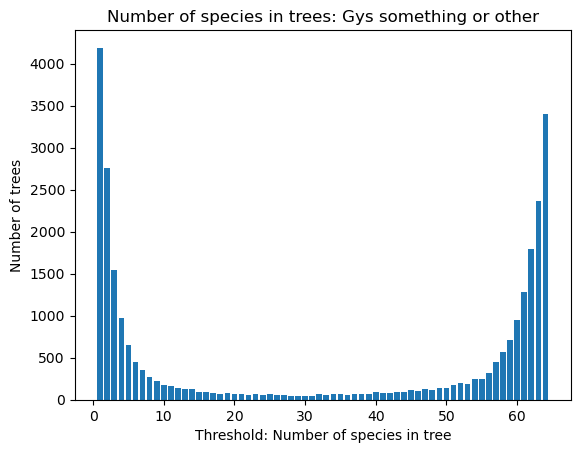

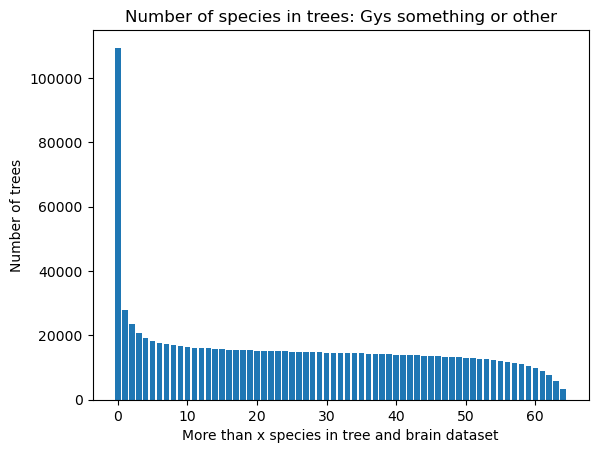

In [8]:
# Plot trees with x number of species in brain size data
sorted_dict = dict(sorted(count_brain.items()))
del sorted_dict[0]

import matplotlib.pyplot as plt
plt.bar(sorted_dict.keys(), sorted_dict.values())
plt.xlabel("Threshold: Number of species in tree")
plt.ylabel("Number of trees") 
plt.title("Number of species in trees: Gys something or other")
plt.show()

# Plot reverse cdf thing
threshold = {i:0 for i in count_brain.keys()}
for key, value in count_brain.items():
    threshold[key] = sum([v for k, v, in count_brain.items() if k >= key])

import matplotlib.pyplot as plt
plt.bar(threshold.keys(), threshold.values())
plt.xlabel("More than x species in tree and brain dataset")
plt.ylabel("Number of trees") 
plt.title("Number of species in trees: Gys something or other")
plt.show()